In [1]:
import numpy as np
from fractions import Fraction
import qiskit.visualization
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

In [2]:
def continued_fraction_iterative(x, iter):
    if iter == 0 or isinstance(x, int):
        return int(np.floor(x))
    
    # Store the terms in reverse order
    terms = []
    current_x = x
    
    # Calculate all floor values first
    for _ in range(iter):
        floor_val = int(np.floor(current_x))
        terms.append(floor_val)
        
        # Break if we have a whole number
        if np.mod(current_x, 1) == 0:
            break
            
        current_x = 1/np.mod(current_x, 1)
    
    # Build the fraction from bottom up
    result = terms[-1]  # Start with the last term
    
    # Work backwards through the terms
    for term in reversed(terms[:-1]):
        result = term + Fraction(1, result)
    
    return result

In [3]:
def get_order(phi,x,L):
    k=1
    estimated_r = continued_fraction_iterative(phi,k)
    while estimated_r.denominator()<L and  k< 200:
        r = estimated_r.denominator()
        if pow(x,r,L) == 1:
            return r
        k+=1
        estimated_r = continued_fraction_iterative(phi,k)

## Defining stuff to implemnt Controlled qft adder with arbitrary mod N

In [4]:
def sim(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}+{y_val} mod {N} = ${(x_val+y_val)%N }_{{10}}$ = ${((x_val+y_val)%N):0{n_qubits}b}_{{2}}$ "))

def simGetCounts(circuit, simulator, shots):
    return simulator.run(qiskit.transpile(circuit, simulator),shots=shots).result().get_counts(0)

In [5]:
def qft_adder(y_val,x):
    qc = QuantumCircuit(*x,name="qftAdd")
    # Apply QFT 
    qft = QFT(qc.num_qubits, do_swaps=False)
    qc.append(qft,qc.qubits[:] )
    
    # Apply controlled phase rotations
    for i in range(qc.num_qubits):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.p(theta, qc.qubits[i])
    # Apply inverse QFT 
    iqft = QFT(qc.num_qubits, do_swaps=False).inverse()
    qc.append(iqft, qc.qubits[:])
    
    return qc.to_instruction()

In [124]:
def Cqft_adder(y_val,c1,x):
    """
        assuming the first Quantum register is the x+1-register, and the second  is c1
    """

    qc = QuantumCircuit(*x,c1 ,name="CqftAdd")
    # Apply QFT 
    qft = QFT(qc.num_qubits -len(c1), do_swaps=False)
    qc.append(qft,qc.qubits[:-1] )
    
    # Apply controlled phase rotations
    for i in range(qc.num_qubits -len(c1)):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.cp(theta,c1[0], qc.qubits[i])
    # Apply inverse QFT 
    iqft = QFT(qc.num_qubits -len(c1), do_swaps=False).inverse()
    qc.append(iqft, qc.qubits[:-1])
    
    return qc.to_instruction()

In [125]:
def isless( y_val, a,c1,x):
    qc = QuantumCircuit(x,a,c1,name="isLess")
    qc.append(qft_adder(-y_val,[x,a]),[*x,a])
    qc.cx(a,c1)
    qc.append(qft_adder( +y_val,[x,a]),[*x,a])
    return qc.to_instruction()

In [132]:
def Cisless( y_val, a,c1,x,control):
    qc = QuantumCircuit(x,a,c1,control,name="isLess")
    qc.append(Cqft_adder(-y_val,control,[x,a]),[*x,*a,*control])
    qc.cx(a,c1)
    qc.append(Cqft_adder( +y_val,control,[x,a]),[*x,*a,*control])
    return qc.to_instruction()

In [133]:
qr = QuantumRegister(5,'x')
aux = QuantumRegister(1,'a')
circ = QuantumCircuit(qr,aux)
for i in range(len(qr)):
        if (5 & (1 << i)):
            circ.x(qr[i])
circ.x(aux)

In [186]:
def addmodN(y_val,N,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c1 = QuantumRegister(1,'cnt')  
    c2 = QuantumRegister(1,'cnt1')  
    qc = QuantumCircuit(x, a, c1,c2,name ="x+y mod N")
    qc.append(isless(N-y_val,a,c1,x),[*x,*a,*c1])
    qc.append(qft_adder(y_val,[x]),x)
    qc.x(c1)
    qc.append(Cqft_adder(-N, c1,[x]), [*x,*c1])
    return qc

In [187]:
def CaddmodN(y_val,N,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c1 = QuantumRegister(1,'c')  
    c2 = QuantumRegister(1,'Control')  
    qc = QuantumCircuit(x, a, c1,c2,name ="C x+y mod N")
    qc.append(Cisless(N-y_val,a,c1,x,c2),[*x,*a,*c1,*c2])# checks for x<=N-y
    qc.append(Cqft_adder(y_val,c2,[x]),[*x,*c2])
    qc.cx(c2,c1)
    qc.append(Cqft_adder(-N, c1,[x]), [*x,*c1])
    return qc

In [188]:
def get_circuit(x_val,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c1 = QuantumRegister(1,'c')  
    c2 = QuantumRegister(1,'Control')  

    clb = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(x,a,c1,c2,clb)
    for i in range(n_qubits):
        if (x_val & (1 << i)):
            qc.x(qc.qubits[i])
    return qc

In [198]:
x_val =9
y_val = 32
N_val=12
# ensures that x register is large enough to fit arbitrary mod N operation
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 

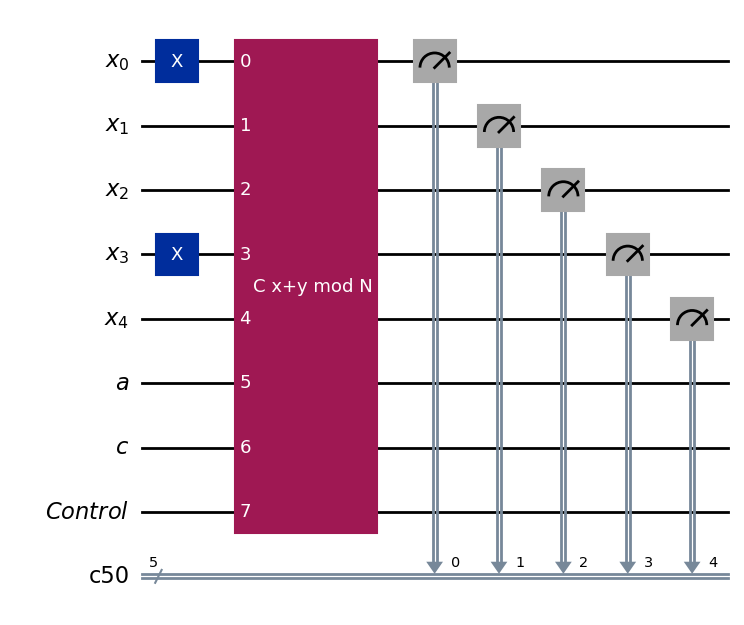

In [199]:
# rerun this cell if the execution fails on the first run
circuit = get_circuit(x_val,n_qubits)
# circuit.x(circuit.qregs[3])
circuit.append(CaddmodN(y_val,N=N_val,n_qubits=n_qubits),circuit.qubits[:])

circuit.measure(circuit.qregs[0][:],circuit.cregs[0][:n_qubits])
# circuit.measure(circuit.qregs[1][0],circuit.cregs[0][-1])
circuit.draw('mpl')

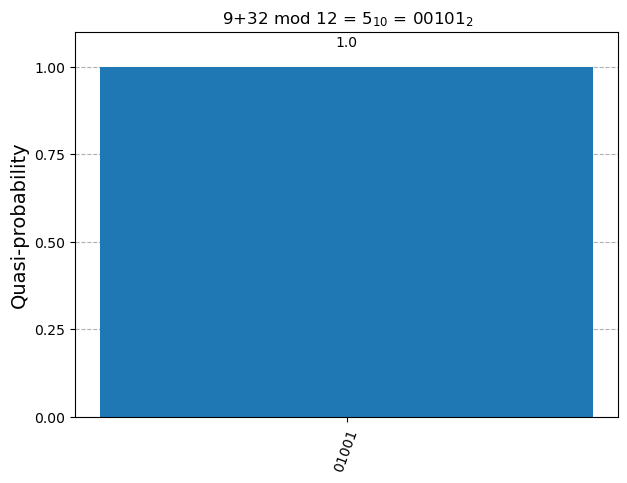

In [200]:
sim(circuit,AerSimulator(),1000,x_val,y_val,N_val,5)

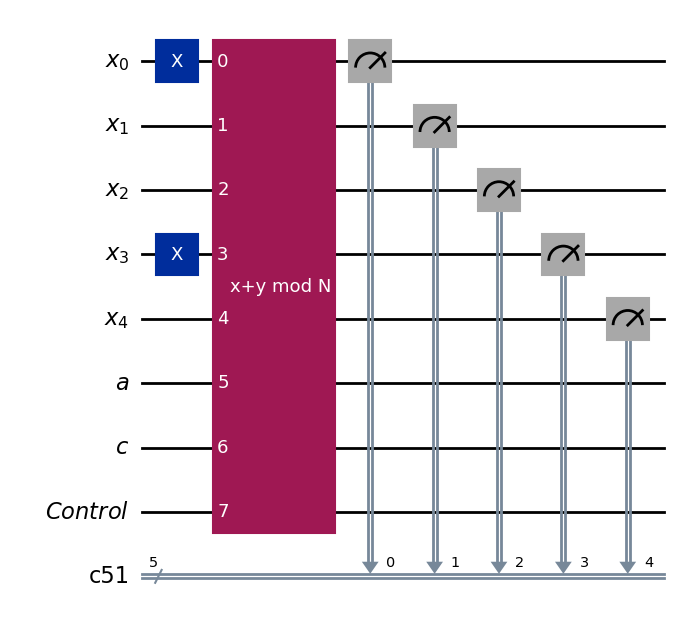

In [201]:
circuit = get_circuit(x_val,n_qubits)
circuit.append(addmodN(y_val,N=N_val,n_qubits=n_qubits),circuit.qubits[:])

circuit.measure(circuit.qregs[0][:],circuit.cregs[0][:n_qubits])
# circuit.measure(circuit.qregs[1][0],circuit.cregs[0][-1])
circuit.draw('mpl')

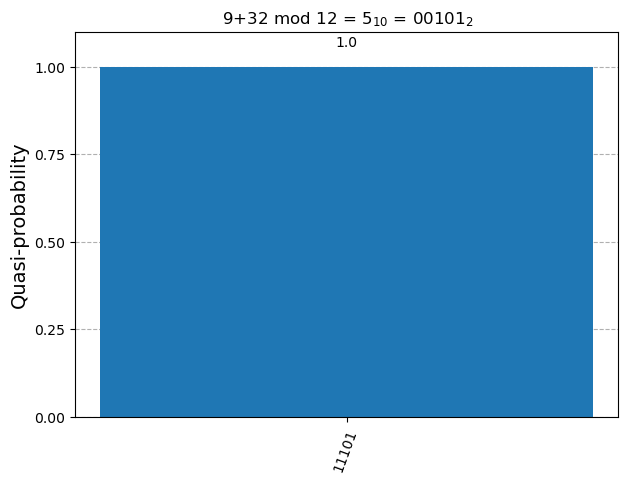

In [202]:
sim(circuit,AerSimulator(),1000,x_val,y_val,N_val,5)